In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import normaltest

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
sns.set_context('notebook')

In [190]:
data = pd.read_csv('insurance.csv')
data.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [191]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [192]:
data['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [193]:
columns = data.select_dtypes(exclude='object').columns.to_list()


### Checking the distribution of some features using histograms 

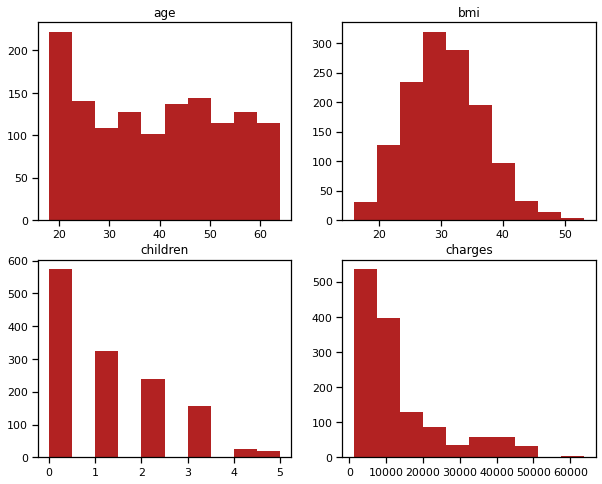

In [194]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axes= axes.ravel()
columns = data.select_dtypes(exclude='object').columns.to_list()

for ax, col in zip(axes,columns):
    ax.hist(data[col], color ='firebrick')
    ax.set_title(col)

### Compare the charges with the number of children

<AxesSubplot:xlabel='children', ylabel='charges'>

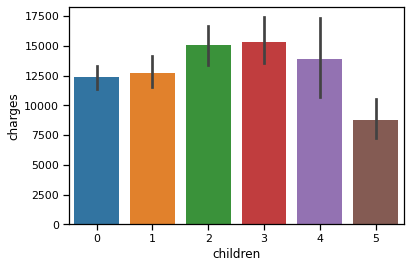

In [195]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
# axes= axes.ravel()
# columns = data.select_dtypes(exclude='object').columns.to_list()

# for ax, col in zip(axes,columns):
#     sns.regplot(x=col,y='charges', ax=ax, data=data, label=col)
#     ax.legend()


sns.barplot(x=data['children'], y = data['charges'])

### A scatterplot to see how charges are affected by bmi and whether the person is a smoker or not.
High correlation is observed between bmi and the charges of people who smoke. A very mild correation is observed for the same features for non-smokers. 

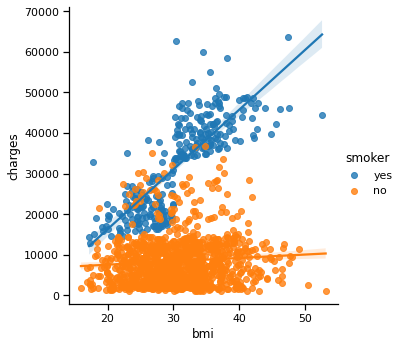

In [196]:
sns.lmplot(x='bmi', y='charges', data=data, hue='smoker')

## Feature transformation

### Checking normality 

In [197]:
# Using D'Agostino K^2 test
normaltest(data['charges'])

NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)

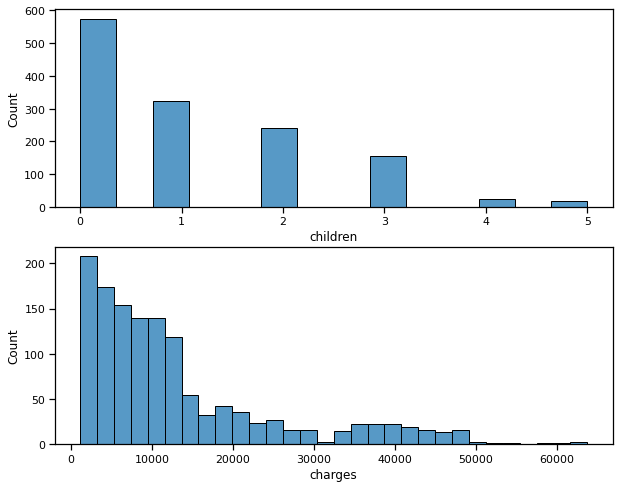

In [198]:
# checking for skewness:
numeric_data = data.select_dtypes(include='number')
numeric_data.skew()
skewed_cols = numeric_data.columns[abs(numeric_data.skew())>0.75].to_list()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
for i,ax in zip(skewed_cols,axes):
    sns.histplot(data=data, x=i, ax=ax)



High skewness and p values suggest that the distribution is not normal

### Skewed Variables are transformed using log transformation

<AxesSubplot:xlabel='charges', ylabel='Count'>

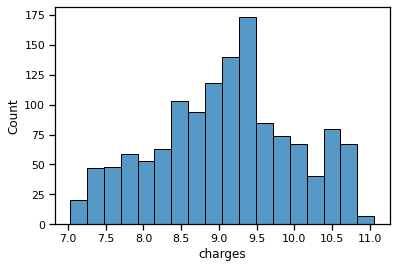

In [199]:
for i in skewed_cols:
    data[i] = np.log1p(data[i])
sns.histplot(data = data, x='charges')

In [200]:
num_cols = data.select_dtypes(include='number')


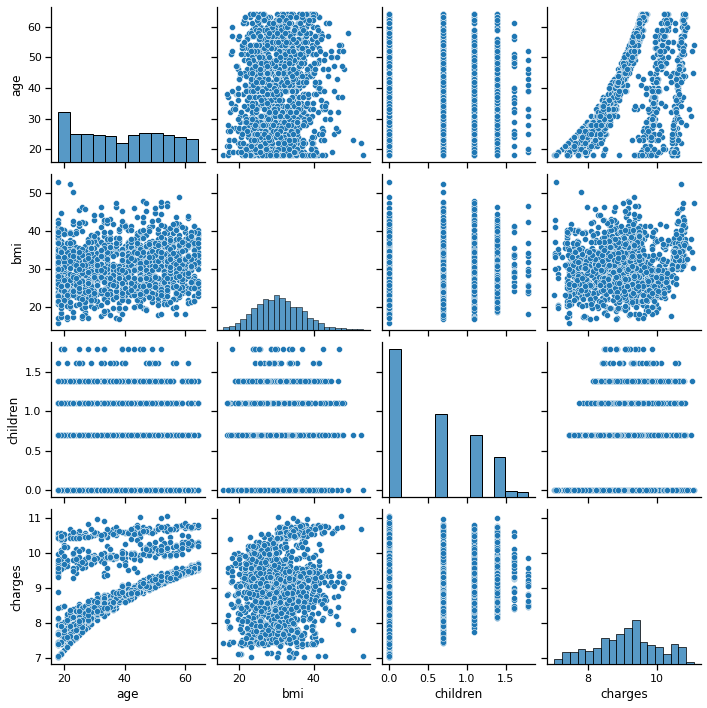

In [201]:
# Fill the null values by 0 or appropriate agg value 
num_cols = data.select_dtypes(include='number')
sns.pairplot(data=num_cols)


### Checking multicollinearity using Variable Inflation Factor

In [202]:
# Calculating the variance inflation factor

def VIF(Dataframe):
    '''
      We use the linear regression for each of feature and determine the corresponding r^2 and VIF 
    '''
    from sklearn.metrics import r2_score
    from sklearn.linear_model import LinearRegression
    
    features = Dataframe.columns.to_list()
    for i in features:
        x = Dataframe.loc[:, Dataframe.columns != i]
        y = Dataframe.loc[:, Dataframe.columns == i]
#         model = sm.OLS(y, x)                       #Fit ordinary least squares method
#         y_pred = model.fit()
        lr = LinearRegression().fit(x,y)
        
        y_pred = lr.predict(x)
        R2_score = r2_score(y, y_pred)
        VIF = 1/(1-R2_score)
        print(f'The VIF score for {i} is {VIF}')
    
VIF(num_cols)
    


The VIF score for age is 1.392689574611863
The VIF score for bmi is 1.0201556351628163
The VIF score for children is 1.0330533506497286
The VIF score for charges is 1.4398093964178365


### As the VIF score < 10, there is no need to remove any features

### Encoding categorical variables using pd.get_dummies()

In [203]:
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'])
data

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0.000000,9.734236,1,0,0,1,0,0,0,1
1,18,33.770,0.693147,7.453882,0,1,1,0,0,0,1,0
2,28,33.000,1.386294,8.400763,0,1,1,0,0,0,1,0
3,33,22.705,0.000000,9.998137,0,1,1,0,0,1,0,0
4,32,28.880,0.000000,8.260455,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,1.386294,9.268755,0,1,1,0,0,1,0,0
1334,18,31.920,0.000000,7.699381,1,0,1,0,1,0,0,0
1335,18,36.850,0.000000,7.396847,1,0,1,0,0,0,1,0
1336,21,25.800,0.000000,7.605365,1,0,1,0,0,0,0,1


### We see that there is a relationship between age and charges. PlolynomialFeatures could be of use here.

In [204]:
poly_feature = ['age']
pf = PolynomialFeatures(degree=2)
pf.fit(data[poly_feature])

new = pd.DataFrame(pf.transform(data[poly_feature]), columns = pf.get_feature_names_out(input_features=poly_feature))
new=new.drop(['1','age'], axis=1)
new
#data = pd.concat([data, new], axis=0, join='outer')
#data
data_new = data.join(new)
data_new

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age^2
0,19,27.900,0.000000,9.734236,1,0,0,1,0,0,0,1,361.0
1,18,33.770,0.693147,7.453882,0,1,1,0,0,0,1,0,324.0
2,28,33.000,1.386294,8.400763,0,1,1,0,0,0,1,0,784.0
3,33,22.705,0.000000,9.998137,0,1,1,0,0,1,0,0,1089.0
4,32,28.880,0.000000,8.260455,0,1,1,0,0,1,0,0,1024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,1.386294,9.268755,0,1,1,0,0,1,0,0,2500.0
1334,18,31.920,0.000000,7.699381,1,0,1,0,1,0,0,0,324.0
1335,18,36.850,0.000000,7.396847,1,0,1,0,0,0,1,0,324.0
1336,21,25.800,0.000000,7.605365,1,0,1,0,0,0,0,1,441.0


### 1) Using linear regression and KFolds to make a prediction

In [205]:
X = data_new.drop('charges', axis=1)
y = data_new['charges']

In [206]:
# Creating a Kfolds object
kf = KFold(shuffle=True, random_state=72018, n_splits=5)
# Creating a standard scalar object
sc = StandardScaler()
# Creating a linear regression object
lr = LinearRegression()

In [207]:
# Creating a pipeline
estimator= Pipeline([('scalar', sc),
                    ('linear regression', lr)])
# we have skipped polynomial transform as it was performed before

In [208]:
# # Making predictions
# predictions = cross_val_predict(estimator, X, y, cv=kf)
# r2_score(y, predictions)

In [209]:
Scores = []
for train_index, test_index in kf.split(X):
    
    train_x, test_x, train_y, test_y = (X.iloc[train_index,:],
                                       X.iloc[test_index,:],
                                       y[train_index],
                                       y[test_index])
                
    estimator.fit(train_x, train_y)
    y_pred = estimator.predict(test_x)
    score = r2_score(test_y.values, y_pred)
    Scores.append(score)


In [210]:
# The mean r^2 score for linear regression:
print(f'The R^2 score for the linear regression model is :{np.round(np.mean(Scores),4)}')

The R^2 score for the linear regression model is :0.7636


### 2) Using GridsearchCV to find hyperparameters for Ridge/LASSO regression

In [211]:
# Defining a parameter grid for hyperparameters to be used in Ridge and LASSO
# Adding the polunomial features to the pipeline now

X = data.drop('charges', axis=1)
y = data['charges']

best_estimator = Pipeline([('PolyFeatures', pf),
                            ('scaler', sc),
                            ('Lasso', Lasso(max_iter=1000000))])

parameters = {'PolyFeatures__degree': [1,2,3,],
             'Lasso__alpha': np.geomspace(1e-5,10, 8)}
grid = GridSearchCV(best_estimator, parameters, cv=kf)

In [212]:
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('PolyFeatures', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('Lasso', Lasso(max_iter=1000000))]),
             param_grid={'Lasso__alpha': array([1.00000000e-05, 7.19685673e-05, 5.17947468e-04, 3.72759372e-03,
       2.68269580e-02, 1.93069773e-01, 1.38949549e+00, 1.00000000e+01]),
                         'PolyFeatures__degree': [1, 2, 3]})

In [213]:
# To check the best r^2 score obtained and corresponding combination of hyperparameters
grid.best_score_, grid.best_params_

(0.8334240028904162,
 {'Lasso__alpha': 0.0005179474679231213, 'PolyFeatures__degree': 2})

In [214]:
y_predict_lasso = grid.predict(X)
# r^2 score for Lasso regression
print(f'The R^2 score for the LASSO regression model is :{np.round(r2_score(y, y_predict_lasso),4)}')

The R^2 score for the LASSO regression model is :0.8437


### Using GridSerchCV for Ridge regression

In [215]:
# Defining a parameter grid for hyperparameters to be used in Ridge and LASSO
# Adding the polunomial features to the pipeline now

X = data.drop('charges', axis=1)
y = data['charges']

best_estimator = Pipeline([('PolyFeatures', pf),
                            ('scaler', sc),
                            ('Ridge', Ridge(max_iter=10000))])

parameters = {'PolyFeatures__degree': [1,2,3,],
             'Ridge__alpha': np.geomspace(1,50, 8)}
grid = GridSearchCV(best_estimator, parameters, cv=kf)

In [216]:
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('PolyFeatures', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('Ridge', Ridge(max_iter=10000))]),
             param_grid={'PolyFeatures__degree': [1, 2, 3],
                         'Ridge__alpha': array([ 1.        ,  1.74867862,  3.05787692,  5.347244  ,  9.35061127,
       16.35121402, 28.5930184 , 50.        ])})

In [217]:
y_pred_ridge = grid.predict(X)
grid.best_score_, grid.best_params_

(0.8329027673589582,
 {'PolyFeatures__degree': 2, 'Ridge__alpha': 3.057876921606392})

In [218]:
print(f'The R^2 score for the LASSO regression model is :{np.round(r2_score(y, y_pred_ridge),4)}')

The R^2 score for the LASSO regression model is :0.8437


## Summary: 
### We have bulit a regression model to predict the personal mediacal health insurance cost based on various features such as bmi, age , gender etc. using simple, LASSO and Ridge regression
### By taking a look at the r^2 score, we can say that the LASSO and Ridge regression give a better r^2 and subsequently a better model.

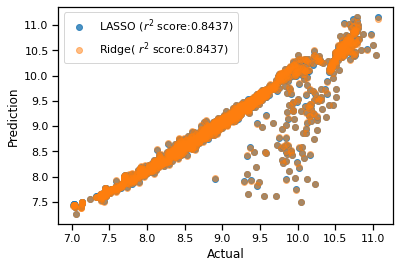

In [219]:
sns.set_context('notebook')
plt.scatter(y, y_predict_lasso, alpha=0.8, label=f'LASSO ($r^2$ score:{np.round(r2_score(y, y_predict_lasso),4)})')
plt.scatter(y, y_pred_ridge, alpha=0.5,  label=f'Ridge( $r^2$ score:{np.round(r2_score(y, y_pred_ridge),4)})')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.legend()